In [58]:
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as r
import numpy as np
import cv2
import imghdr
import os

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50V2, Xception, EfficientNetB4
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from keras import backend
from collections import Counter
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

CLEAN = False
  
print(f'Tensorflow version {tf.version.VERSION}')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Removing nontype files is: {CLEAN}')


Tensorflow version 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Removing nontype files is: False


## Data processing

In [59]:
VAL_SPLIT = 0.25
HEIGHT = 300  #common aspect 2:3
WIDTH = 200
BATCH_SIZE = 16
PATH_TRAIN = 'C:/Users/crims/Tensorflow/PublisherIdetification/realpublishers/training/'
PATH_TEST = 'C:/Users/crims/Tensorflow/PublisherIdetification/realpublishers/testing/'

train_generator = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)
test_generator = ImageDataGenerator(rescale=1./255)

print('Training folder:')
train_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(WIDTH, HEIGHT),
                                                 class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                 subset = 'training')

class_counter = list(Counter(train_data.classes).values())
class_names = list(train_data.class_indices)
class_num = train_data.num_classes
print(f'Class and num {dict(zip(class_names, class_counter))}') 

print()
print('Validation folder:')
valid_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(WIDTH, HEIGHT),
                                                 class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                 subset = 'validation')
print()
print('Test folder:')
test_data = test_generator.flow_from_directory(PATH_TEST, target_size=(WIDTH, HEIGHT), 
                                               class_mode=None, batch_size=1, 
                                               shuffle=False)


Training folder:
Found 9809 images belonging to 4 classes.
Class and num {'IEEE': 144, 'Macmillan': 2586, 'Springer Nature': 5768, 'Wolters Kluwer Health': 1311}

Validation folder:
Found 3269 images belonging to 4 classes.

Test folder:
Found 0 images belonging to 1 classes.


## Cleaning data (run only once per dataset)

In [60]:
if CLEAN == True:
    filenames = train_data.filenames
    n = 0
    while n < train_data.n:
        path = f'{PATH_TRAIN}{filenames[n]}'
        image = cv2.imread(path)
        img_type = imghdr.what(path)
        if img_type != "jpeg":
            print(f'Removing image from {path}')
            os.remove(path)
            n += 1
        else:
            n += 1
    print('All done!')    
else:
    print('Skipping clean')

Skipping clean


In [61]:
# size = os.stat(real_path).st_size
# def getmd5(filename):
#     file_txt = open(filename,'rb').read()
#     m = hashlib.md5(file_txt)
#     return m.hexdigest()
# if size in all_size.keys():
#     new_md5 = getmd5(real_path)
#     if all_size[size][1] == '':
#         all_size[size][1] = getmd5(all_size[size][0])
#     if new_md5 in all_size[size]:
#         os.remove(real_path)
#         Print('delete', file)
#         total_delete += 1
#     else:
#         all_size[size].append(new_md5)
# else:
#     all_size[size] = name_and_md5

## Model setup & parameters

In [62]:
#Parameters
NETWORK = 'Xception'
LEARN_RATE = 5e-4    #xception ~ 5e-4, efficient ~ 9e-5 
OPTIMIZER = 'Adam'  #adam, rms, sgd
POOLING = 'avg'     #max, avg, none
EPOCHS = 30
NUM_TRAIN_BATCHES = 100 #BATCH_SIZE * NUM_TRAIN_BATCHES is images processed per epoch
NUM_VAL_BATCHES = NUM_TRAIN_BATCHES * VAL_SPLIT

choice_model = {'Xception' : Xception(include_top=False, weights='imagenet', 
                                        input_shape=(WIDTH, HEIGHT, 3), pooling=POOLING),
                'Efficient' : EfficientNetB4(include_top=False, weights='imagenet', 
                                        input_shape=(WIDTH, HEIGHT, 3), pooling=POOLING),
                'Resnet50' : ResNet50V2(include_top=False, weights='imagenet', 
                                        input_shape=(WIDTH, HEIGHT, 3), pooling=POOLING)}
base = choice_model[NETWORK]

choice_opt = {'RMS' : tf.keras.optimizers.RMSprop(learning_rate=LEARN_RATE), #default 1e-2
                'Adam': tf.keras.optimizers.Adam(learning_rate=LEARN_RATE), #default 1e-3
               'SGD' : tf.keras.optimizers.SGD(learning_rate=LEARN_RATE)}  #default 1e-3
opt = choice_opt[OPTIMIZER]

x = base.output
#x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(class_num, activation='softmax')(x)
model = Model(base.input, x)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=opt)

#cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

tensorflow_callback = k.callbacks.TensorBoard(
    log_dir= f'tensorboard_logs/{NETWORK}_{OPTIMIZER}_E{EPOCHS}B{BATCH_SIZE}_lr{LEARN_RATE}_pool{POOLING}', 
    histogram_freq=1, write_graph=True, write_images=True
)

model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 200, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 149, 32)  864         input_22[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 149, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 149, 32)  0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## Run model

In [63]:
#Train model
history = model.fit(train_data, validation_data=valid_data, callbacks=[tensorflow_callback],
                       epochs=EPOCHS, steps_per_epoch=NUM_TRAIN_BATCHES, validation_steps=NUM_VAL_BATCHES, 
                       batch_size=BATCH_SIZE, verbose =1)

model.save(f'{NETWORK}_publisherid')

Epoch 1/30
100/100 [==============================] - 43s 368ms/step - loss: 0.4738 - acc: 0.8331 - val_loss: 2.1199 - val_acc: 0.6975
Epoch 2/30
100/100 [==============================] - 33s 329ms/step - loss: 0.3590 - acc: 0.8850 - val_loss: 0.8532 - val_acc: 0.7375
Epoch 3/30
100/100 [==============================] - 33s 334ms/step - loss: 0.3243 - acc: 0.8950 - val_loss: 0.9681 - val_acc: 0.7525
Epoch 4/30
100/100 [==============================] - 33s 333ms/step - loss: 0.2637 - acc: 0.9062 - val_loss: 0.3903 - val_acc: 0.8650
Epoch 5/30
100/100 [==============================] - 33s 332ms/step - loss: 0.2239 - acc: 0.9237 - val_loss: 0.2950 - val_acc: 0.9150
Epoch 6/30
100/100 [==============================] - 34s 338ms/step - loss: 0.1950 - acc: 0.9338 - val_loss: 0.3298 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 34s 340ms/step - loss: 0.1406 - acc: 0.9521 - val_loss: 0.3000 - val_acc: 0.8975
Epoch 8/30
100/100 [==============================] - 3

C:\Users\crims\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: Xception_publisherid\assets


## Model evaluation 

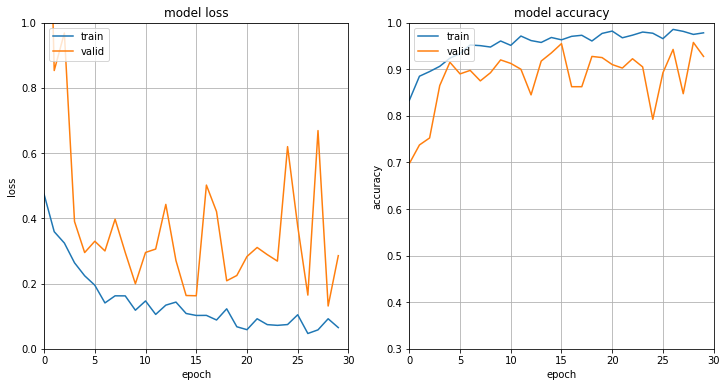

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.xlabel('epoch')
plt.xlim([0, EPOCHS])
plt.grid()
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim([0.3, 1])
plt.xlabel('epoch')
plt.xlim([0, EPOCHS])
plt.legend(['train', 'valid'], loc='upper left')
plt.grid()
plt.show()

## Predictor

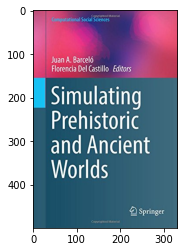

1st predict Springer Nature with confidence 63.279%
2nd predict Macmillan with confidence 23.405%
Answer is Springer Nature\Thumbnail1392.jpg


In [65]:
n = r.randint(0,valid_data.n)
filenames = valid_data.filenames
path = f'{PATH_TRAIN}{filenames[n]}'
pic = mpimg.imread(path)
plt.imshow(pic)
plt.show()

img = tf.keras.preprocessing.image.load_img(path, target_size=(WIDTH, HEIGHT))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_processed = tf.keras.applications.xception.preprocess_input(img_batch)

prediction = model.predict(img_processed)
Top_index = np.argsort(np.max(prediction, axis=0))[-1]
Second_index = np.argsort(np.max(prediction, axis=0))[-2]

sort = np.sort(max(prediction))
print(f'1st predict {class_names[Top_index]} with confidence {round(sort[len(sort) - 1]*100, 3)}%')
print(f'2nd predict {class_names[Second_index]} with confidence {round(sort[len(sort) - 2] * 100, 3)}%')           
print(f'Answer is {filenames[n][:]}')
